In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from numpy.random import normal
from scipy import constants
from commpy.utilities  import signal_power, upsample
from utils.dsp import firFilter, pulseShape, eyediagram, lowPassFIR
from utils.models import mzm
from numpy.fft import fft, ifft, fftshift, fftfreq

#from numpy import cos, sin, log10, sqrt
#from numpy.fft import fft, fftfreq, fftshift
#from scipy.signal import convolve
#mport pandas as pd


In [2]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize
from IPython.display import display, Math

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
figsize(10, 3)

# Comunicações Ópticas

# Detecção de sinais ópticos e ruído


<img src="./figuras/Rx_OOK.png" width="400">

## Fontes de ruído em receptores ópticos

### Ruído de disparo (ou ruído balístico)

A corrente $I(t)$ gerada pela conversão da potência de sinal óptico incidente no fotodiodo pode ser escrita como

$$
\begin{equation}\label{eq1}
I(t)=I_{p}(t) + i_{s}(t)
\end{equation}
$$

em que $i_{s}(t)$ representa um processo aleatório conhecido como ruído de disparo e $I_{p}(t)$ corresponde à corrente proporcional à responsividade e à potência óptica incidente no fotodiodo, data por

$$
\begin{equation}\label{eq2}
I_{p}(t)=R_{d} P_{\text {in}}(t).
\end{equation}
$$

O ruído de disparo $i_{s}(t)$ é bem caracterizado como um processo aleatório estacionário com estatística de Poisson que, em geral, é aproximada por uma estatística gaussiana, o que facilita o seu tratamento matemático.

Seja $R_{i_s}(\tau)$ a função de autocorrelação de $i_s(t)$ será dada por

$$
\begin{equation} \label{eq3}
R_{i_s}(\tau) = E\left[i_s(t)i_s(t+\tau)\right].
\end{equation}
$$

Pelo teorema de Wiener-Kinchin, a densidade espectral e potência $S_{i_s}(f)$ associada a $i_s(t)$ é dada pela transformada de Fourier de $R_{i_s}(\tau)$, de modo que 

$$
\begin{align}
S_{i_s}(f)    &= \int_{-\infty}^{\infty}R_{i_s}(\tau)e^{-2\pi f \tau} d\tau\nonumber \\
R_{i_s}(\tau) &= \int_{-\infty}^{\infty}S_{i_s}(f)e^{2\pi f \tau} df\label{eq4}
\end{align}
$$

No caso do ruído de disparo, a densidade espectral de potência é constante e dada por $S_{i_s}(f)=q\bar{I}_p$, em que 
$\bar{I}_p$ é o valor médio da fotocorrente, definido por

$$
\begin{equation}\label{eq5}
\bar{I}_p = \frac{1}{T_s} \int_{-T_s/2}^{T_s/2}E[I_p(t)]dt.
\end{equation}
$$

em que $T_s$ é o período de sinalização da transmissão.

A potência do ruído de disparo corresponderá a sua variância $\sigma_{s}^{2}$. Seja $B$ a banda do receptor óptico em $Hz$, $\sigma_{s}^{2}$ pode ser calculada por

$$
\begin{align}
\sigma_{s}^{2} &= E\left[i_{s}^{2}(t)\right] = R_{i_s}(0) \nonumber\\
               &= \int_{-\infty}^{\infty} S_{i_s}(f) df = \int_{-B}^{B} S_{i_s}(f) df \nonumber \\
               &= 2 q \bar{I}_{p} B \label{eq6}
\end{align}
$$

Uma vez que a corrente de escuro $I_d$ do fotodiodo (*dark current*) também contribui para o ruído de disparo, a mesma deve ser incluída em (\ref{eq6}), de modo que a expressão final para a variância do ruído de disparo será dada por

$$
\begin{equation}\label{eq7}
\sigma_{s}^{2} = 2 q (\bar{I}_{p} + I_d) B
\end{equation}
$$


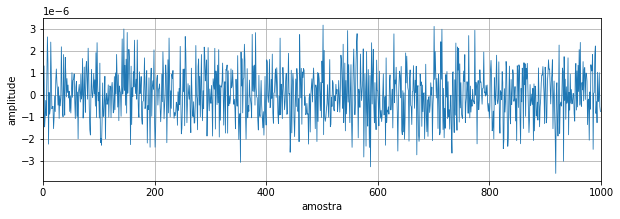

In [29]:
Pin_dBm = -1   # potência óptica média em dBm
Rd  = 0.5      # responsividade em A/W
Id  = 100e-9   # corrente de escuro em nA
B   = 10e9     # banda do receptor em Hz

q  = constants.value(u'elementary charge') # carga elementar do elétron

Pin = 10**(Pin_dBm/10)*1e-3 # potência óptica média em W
Ip  = Rd*Pin

# ruído de disparo (ruído gaussiano branco)
Namostras = 100000

σ2_s = 2*q*(Ip + Id)*B  # variância
μ    = 0                # média

σ     = np.sqrt(σ2_s) 
Is    = normal(μ, σ, Namostras)  

# plotas as primeiras 1000 amostras
plt.plot(Is[0:1000],linewidth = 0.8);
plt.xlim(0,1000)
plt.ylabel('Is')
plt.xlabel('amostra')
plt.grid()

<IPython.core.display.Math object>

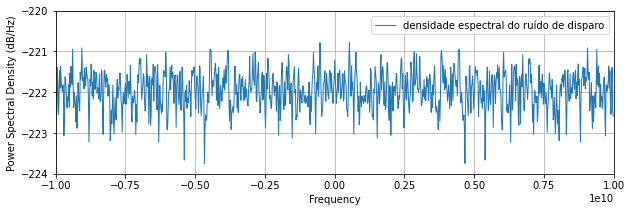

In [30]:
fa = 20e9   # frequência de amostragem considerada

plt.figure()
plt.xlim(-fa/2, fa/2)
plt.psd(Is, Fs=fa, label='densidade espectral do ruído de disparo',linewidth=1,  sides='twosided', NFFT=1024); # estima densidade espectral do sinal
plt.legend()

display(Math('S_{i_s}(f) = %.2f \;\mathrm{dBW/Hz}'%(10*np.log10(σ2_s/(2*B)))))

#### Calculando a potência de um sinal

$$\begin{equation}\label{eq8}
P_x = E\left[X^2\right] = \mu^2 + \sigma^2\approx \frac{1}{N}\sum_{k=1}^{N} x^2[k]
\end{equation}
$$

In [6]:
Pn = signal_power(Is)

print('Potência do ruído (em W)   = %.2e W' %Pn) 
print('Potência do ruído (em dBm) = %.2f dBm' %(10*np.log10(Pn/1e-3))) 

Potência do ruído (em W)   = 1.27e-12 W
Potência do ruído (em dBm) = -88.98 dBm


### Ruído térmico

$$
\begin{equation}\label{eq10}
S_{T}(f)=2 k_{B} T / R_{L}
\end{equation}
$$

### Razão sinal-ruído (*signal-to-noise ratio* - SNR)

A relação sinal-ruído (ou razão sinal-ruído, *signal-to-noise ratio* (SNR), em Inglês) é uma das grandezas mais importantes na engenharia de sistemas de comunicações. A SNR é um indicador da presença de ruído no sistema, ou seja, a presença de distorções aleatórias e indesejáveis que afetam os sinais que carregam informação, dificultando ou impossibilitando o processo de comunicação. 

A SNR é definida como sendo a razão entre a potência de sinal $P_s$ e a potência do ruído $P_N$ observadas num dado sistema:

$$SNR = \frac{P_s}{P_N}$$

em que $P_s = E\left[|s(t)|^2\right]$ e $P_N=E\left[|n(t)|^2\right]$, com $E[.]$ denotando valor esperado.

Quando expressa em decibéis (dB), a SNR é dada por

$$ SNR_{dB} = 10\log_{10}P_s-10\log_{10}P_N.$$

Quanto maior a SNR maior a diferença entre a potência do sinal de interesse e a potência do ruído adicionado á mesma. Dessa forma, quanto maior a SNR melhor a qualidade do sinal.

Um dos modelos mais importantes para o ruído (talvez o modelo mais importante) é o modelo de ruído branco gaussiano aditivo (*additive white Gaussian noise* (AWGN)). Nesse modelo, o ruído é representado por um processo aleatório gaussiano, ou seja, para cada instante $t$ no tempo, o ruído $n(t)$ adicionado ao sinal é dado por uma variável aleatória gaussiana de média zero e uma certa variância $\sigma^2$. 

$$
\begin{array}{lcclll}
\hline
\text { Parâmetro } & \text { Símbolo } & \text { Unidade } & \text { Si } & \text { Ge } & \text { InGaAs } \\
\hline \text { Comprimento de onda } & \lambda & \mu \mathrm{m} & 0,4-1,1 & 0,8-1,8 & 1,0-1,7 \\
\text { Responsividade } & R_{d} & \mathrm{~A} / \mathrm{W} & 0,4-0,6 & 0,5-0,7 & 0,6-0,9 \\
\text { Eficiência quântica } & \eta & \% & 75-90 & 50-55 & 60-70 \\
\text { Corrente no escuro } & I_{d} & \mathrm{n} \mathrm{A} & 1-10 & 50-500 & 1-20 \\
\text { Tempo de subida } & T_{r} & \mathrm{~ns} & 0,5-1 & 0,1-0,5 & 0,02-0,5 \\
\text { Largura de banda } & \Delta f & \mathrm{GHz} & 0,3-0,6 & 0,5-3 & 1-10 \\
\text { Tensão de polarização } & V_{b} & \mathrm{~V} & 50-100 & 6-10 & 5-6 \\
\hline
\end{array}
$$
<center> Fonte: Tabela 4.1, Agrawal, Sistemas de Comunicações por Fibra Óptica, 4ª edição, 2014. </center>

Potência média do sinal óptico modulado (mW): 0.49 mW
Potência média do sinal óptico modulado (dBm): -3.10 dBm


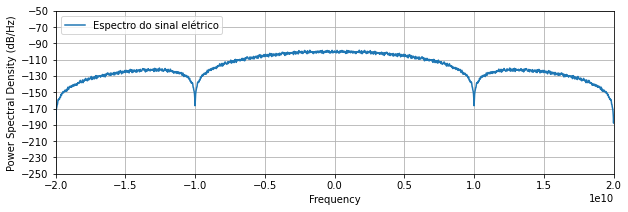

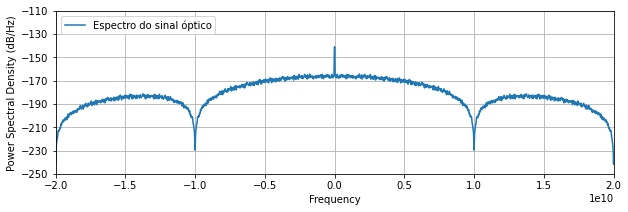

In [33]:
# parâmetros da simulação
SpS = 32

Rs     = 10e9          # Taxa de símbolos (para o caso do OOK Rs = Rb)
Ts     = 1/Rs          # Período de símbolo em segundos
Fa     = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta     = 1/Fa          # Período de amostragem

# parâmetros do modulador
Vπ = 2
Vb = -Vπ/2
Pi = 0.001

# gera sequência de bits pseudo-aleatórios
bits   = np.random.randint(2, size=10000)    
n      = np.arange(0, bits.size)

# mapeia bits para pulsos elétricos
symbTx = 2*bits-1
symbTx = symbTx/np.sqrt(signal_power(symbTx))

# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulso NRZ típico
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# formatação de pulso
sigTx  = firFilter(pulse, symbolsUp)

# modulação óptica
Ai     = np.sqrt(Pi)
sigTxo = mzm(Ai, Vπ, sigTx, Vb)

print('Potência média do sinal óptico modulado (mW): %.2f mW'%(signal_power(sigTxo)/1e-3))
print('Potência média do sinal óptico modulado (dBm): %.2f dBm'%(10*np.log10(signal_power(sigTxo)/1e-3)))

# plota psd
plt.figure();
plt.xlim(-2*Rs,2*Rs);
plt.ylim(-250,-50);
plt.psd(sigTx,Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal elétrico')
plt.legend(loc='upper left');

# plota psd
plt.figure();
plt.xlim(-2*Rs,2*Rs);
plt.ylim(-250,-110);
plt.psd(np.abs(sigTxo)**2,Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal óptico')
plt.legend(loc='upper left');

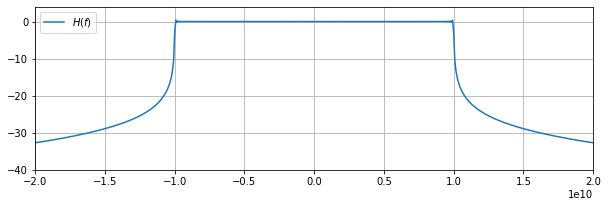

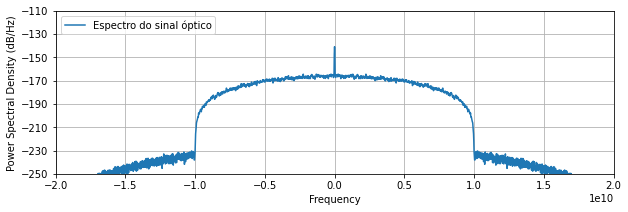

In [32]:
N = 4001
h = lowPassFIR(Rs, Fa, N)

freq = fftshift(fftfreq(h.size, d=1/Fa))
plt.figure()
plt.plot(freq,10*np.log10(np.abs(fftshift(fft(h)))),label='$H(f)$')
plt.legend(loc='upper left');
plt.xlim(-2*Rs,2*Rs);
plt.ylim(-40,4);
plt.grid();

# filtragem Rx
Id_Rx  = firFilter(h, np.abs(sigTxo)**2)

# plota psd
plt.figure();
plt.xlim(-2*Rs,2*Rs);
plt.ylim(-250,-110);
plt.psd(Id_Rx, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal óptico')
plt.legend(loc='upper left');

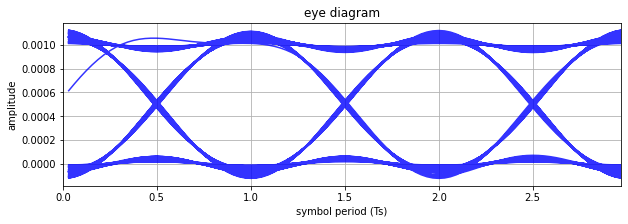

In [34]:
Nsamples = 10000

# diagrama de olho
eyediagram(Id_Rx, Nsamples, SpS)